# Microglia Segmentation U-net
Created: 08/2022
Creator: Emma Davis


In [7]:
# IMPORTS
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps, Image
import os
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from PIL import Image
import random

In [8]:
# ~~~~~~ SET-UP MODEL ~~~~~~
# Change these variables to relevant directories and parameters. num_classes should stay the same
# unless a different annotation approach is being used. img_size should match microglia and mask
# images, which should be square (n x n) and not too large to reduce training time
working_dir = "/home/my_project/"
os.chdir(working_dir)

input_dir = "training_data/microglia"
target_dir = "training_data/masks"
img_size = (384, 384)
num_classes = 3
batch_size = 32

# NUMBER OF IMAGES WE WANT TO USE FOR VALIDATION
# This is usually ~20% of total images
val_samples = 500


In [9]:
# LOAD IN IMAGES
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)


Number of samples: 8112
/home/camp/davise/home/shared/davise/lazemap/training_data/augmented/microglia/mglia_00000.png | /home/camp/davise/home/shared/davise/lazemap/training_data/augmented/masks/mask_00000.png
/home/camp/davise/home/shared/davise/lazemap/training_data/augmented/microglia/mglia_00001.png | /home/camp/davise/home/shared/davise/lazemap/training_data/augmented/masks/mask_00001.png
/home/camp/davise/home/shared/davise/lazemap/training_data/augmented/microglia/mglia_00002.png | /home/camp/davise/home/shared/davise/lazemap/training_data/augmented/masks/mask_00002.png
/home/camp/davise/home/shared/davise/lazemap/training_data/augmented/microglia/mglia_00003.png | /home/camp/davise/home/shared/davise/lazemap/training_data/augmented/masks/mask_00003.png
/home/camp/davise/home/shared/davise/lazemap/training_data/augmented/microglia/mglia_00004.png | /home/camp/davise/home/shared/davise/lazemap/training_data/augmented/masks/mask_00004.png
/home/camp/davise/home/shared/davise/laze

In [67]:
# FUNCTION TO ENCODE MASK
def map_col(im):
    newimdata = []
    blackgs = (0, 0, 0)
    whitegs = (255, 255, 255)
    greygs = (114, 114, 114)
    
    blackmp = (1, 1, 1)
    greymp = (2, 2, 2)
    whitemp = (3, 3, 3)
    for color in im.getdata():
        if color == blackgs:
            newimdata.append(blackmp)
        elif color == greygs:
            newimdata.append(greymp)
        else:
            newimdata.append(whitemp)
    newim = Image.new(im.mode,im.size)
    newim.putdata(newimdata)
    return newim

folder_dir = "/training_data/masks/"
for images in os.listdir(folder_dir):
 
    # check if the image ends with png
    if (images.endswith(".png")):
        im = PIL.ImageOps.autocontrast(load_img(folder_dir + "/" + images))
        map_col(im).save(folder_dir + "/" + images)
        


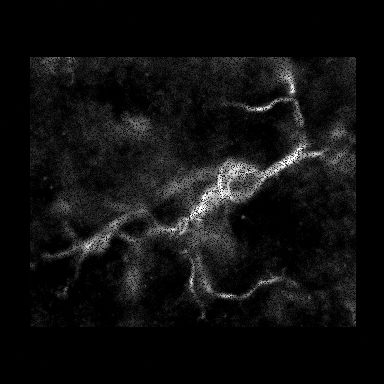

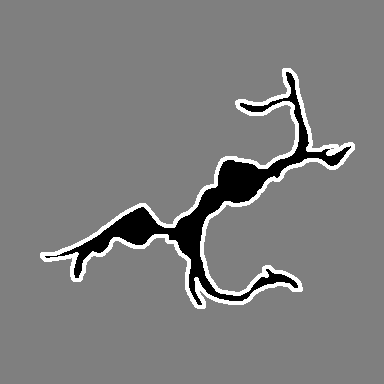

In [4]:
# Display input image #1
display(Image(filename="/training_data/microglia/mglia_00001.png"))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img("/training_data/masks/mask_00001.png"))
display(img)


In [5]:
# HELPER TO ITERATE OVER IMAGE DATA AS ARRAYS
class ArrayHelper(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)

            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


In [7]:
# DEFINE U-NET MODEL
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    # DEFINE ENCODER (CNN) PART OF U-NET
    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # DEFINE DECODER PART OF U-NET
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # COMBINE MODEL PARTS TO MAKE U-NET
    model = keras.Model(inputs, outputs)
    return model


# QUICK RAM CLEAN JUST IN CAE
keras.backend.clear_session()

# BUILD MODEL
model = get_model(img_size, num_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 646, 646, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 323, 323, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 323, 323, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 323, 323, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
# SPLIT IMAGES INTO TESTING AND TRAINING
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = ArrayHelper(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = ArrayHelper(batch_size, img_size, val_input_img_paths, val_target_img_paths)


In [ ]:
# CONFIGURE MODEL FOR TRAINING
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("microglia_seg_model_0423.h5", save_best_only=True)
]

# TRAIN MODEL
epochs = 12
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


2022-09-02 11:11:38.274352: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-02 11:11:38.275118: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599825000 Hz


Epoch 1/12
222/222 [==============================] - 2082s 9s/step - loss: 0.9599 - val_loss: 0.7201
Epoch 2/12
222/222 [==============================] - 2058s 9s/step - loss: 0.2130 - val_loss: 0.7247
Epoch 3/12
222/222 [==============================] - 2092s 9s/step - loss: 0.1513 - val_loss: 0.1929
Epoch 4/12
222/222 [==============================] - 2107s 9s/step - loss: 0.1193 - val_loss: 0.1102
Epoch 5/12
222/222 [==============================] - 2105s 9s/step - loss: 0.0938 - val_loss: 0.0888
Epoch 6/12
222/222 [==============================] - 2095s 9s/step - loss: 0.0750 - val_loss: 0.0699
Epoch 7/12
222/222 [==============================] - 2138s 10s/step - loss: 0.0622 - val_loss: 0.0568
Epoch 8/12
173/222 [======================>.......] - ETA: 7:23 - loss: 0.0530